In [1]:
# NOTES - TAKE 2
# for now, use max captured exposure as zmax, fix later
# obtain pixel value Z from camera with expohttp://192.168.7.2:8888/notebooks/part5_2_hdr.ipynb#sure X, exposure time dt
# want to get irradiance E, given X and dt, E = X / dt
# Z = f(X) = f(E * dt)
# invf(Z) = E * dt
# ln(invf(Z)) = ln(E) + ln(dt)
# g(a) = ln(invf(a)) --> g(Z) = ln(E) + ln(dt)
# ln(E) = g(Z) - ln(dt)
# do this for all Z_ij, E_i, dt_j (pixel i in image j)
# Goal: compute radiance of each pixel, given g, Z, dt

In [2]:
## Initialize everything

%run common.ipynb

Importing libraries...
Done!
Initialize camera and default settings...
Done!
Define functions needed to capture images...
Done!
Generating patterns for projector...
Done!


In [3]:
# FUNCTIONS
# return array of imagesand array of corresponding exposures
def get_images(num_exposures=50):
    # pretend these are exposure times
    time_deltas = []
    tmin = 1
    tmax = 10
    
    # adjust these for better noise reduction
    pixy.set_gamma(1);
    pixy.set_gain(32);
    
    images = []
    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    for x in numpy.linspace(tmin, tmax, num_exposures):
        pixy.set_exposure(x);
        img = get_raw_image();
        img = get_raw_image(); # need to call twice for exposure change to take effect
        images += [img]
        time_deltas += [x]; # x vals
    
    return [images, time_deltas]

# given raw images, get pixels corresponding to specific color
def get_color_images(images, color=-1):
    h = len(images[0])
    w = len(images[0][0])
    
    # given start offsets, return arrays of correct color pixels only
    def helper(i0, j0):
        cimages = []
        for img in cimages:
            cimg = []
            for i in range(i0,h,2):
                row = []
                for j in range(j0,w,2):
                    row += [img[i][j]]
            cimg += [row]
        return cimages
    
    if (color == 0): # red
        return helper(1,1)
    elif (color == 1): # green
        images1 = helper(0,1)
        images2 = helper(1,0)
        # todo
        return images1
    elif (color == 2): # blue
        return helper(0,0)
    else: # dw bout color
        return images
    
# given images
# return array of pixel values corresponding to exposure times
def get_calibration_curve_from_images(images, time_deltas, p0=100, p1=150):
    pixel_values = []
    
    # capture images at various exposures (50 evenly spaced vals btwn 1 and 10)
    # store average pixel value for each image
    max_pixel_value = 0
    for i in range(len(images)):
        img = images[i]
        pixel_values += [numpy.mean(numpy.mean(img[p0:p1,p0:p1]))]; # y vals
        #pixel_values += [numpy.mean(numpy.mean(img[p0:p1,p0:p1]))]; # y vals
        if (pixel_values[-1] > max_pixel_value):
            max_pixel_value = pixel_values[-1]
        
    print("max pixel value=" + str(max_pixel_value))
    return [pixel_values, time_deltas, max_pixel_value]

# Make response curve
# Given pixel values, exposure times, and dataset params
# return function g, g(pixel value) = exposure
# note: exposure = radiance * exposure time
def make_g(pixel_values, exposure_times, num_buckets, zmin, zmax):
    print("num buckets=" + str(num_buckets) + ", zmax=" + str(zmax))
    
    def get_bucket(px):
        frac = (px - zmin) / (zmax+1)
        return int(frac * num_buckets)

    # use numpy.interp instead?
    def lin_interp(x, x0, x1, y0, y1):
        z = (x-x0)/(x1-x0)
        return y0*(z) + y1*(1-z)
    
    # given pixel value x, returns exposure time
    def g(x):
        m = get_bucket(x) # bucket based on pixel val
        if m+1 >= num_buckets: 
            return exposure_times[-1]
        Em = exposure_times[m] # energy/exposure at bucket m
        return numpy.log(Em)
#         x0 = pixel_values[m]
#         x1 = pixel_values[m+1]
#         y0 = exposure_times[m]
#         y1 = exposure_times[m+1]
#         if (x0 >= x1 or y0 > y1):
#             #print("bad vals")
#             return 0
#         return lin_interp(x, x0, x1, y0, y1)        
    
    return g

# make table of g values
def make_gtable(pixel_values, exposure_times, zmin, zmax):
    print("zmax=" + str(zmax))
    gtable = []
    
    # get lowerbounded index in pixel_values that px is close to
    def get_bucket(px):
        for j in range(0,len(pixel_values)-1):
            if (pixel_values[j] <= px) and (px <= pixel_values[j+1]):
                return j
        return len(pixel_values)-1
    
    def lin_interp(x, x0, x1, y0, y1):
        z = (x-x0)/(x1-x0)
        return y0*(z) + y1*(1-z)
    
    for x in range(0,int(zmax)+1):
        m = get_bucket(x)
        if (m == len(pixel_values)-1):
            gtable += [pixel_values[-1]]
        else:
            x0 = pixel_values[m]
            x1 = pixel_values[m+1]
            y0 = exposure_times[m]
            y1 = exposure_times[m+1]
            y = lin_interp(x, x0, x1, y0, y1)
            print(y)
            gtable += [y]
        
    print(gtable)
    
    def g(x):
        if (x >= len(gtable)):
            return 0
        return gtable[int(x)]
    
    return g

# make weight function based on zmin and zmax
def make_w(zmin, zmax):
    def w(z):
        if (z < 0.5*(zmin + zmax)):
            return z - zmin
        else:
            return zmax - z
    return w

# High level: given g, Z_ij, dt_j, return ln(E_i)
# Given set of images, set of exposure times, response function g
# return radiance of pixel @ row r, column c
def get_radiance(images, exposure_times, g, w, r, c):
    weighted_exposures = 0
    weights_sum = 0
    height = len(images[0])
    width = len(images[0][0])
    
#     print(len(images))
#     print(len(exposure_times))
    for j in range(0, len(images)):
        dt = exposure_times[j]
        img = images[j]
        z = img[r][c]
        weighted_exposures += w(z)*(g(z) - numpy.log(dt))
        weights_sum += w(z)
    
    if (weights_sum == 0):
        print("oh no")
    lnE = weighted_exposures / weights_sum
    return pow(numpy.e, lnE)

# helper function to plot functions for debugging
def plot_func(g, zmax):
    # plot exposure time as function of pixel value
    vals = []
    for z in numpy.linspace(0, zmax, 50):
        x = g(z)
        vals += [x]
    plt.plot(vals);
    plt.show();
    
# working with zmax that isn't 255 right now, a temporary fix?
# return images scaled according to zmax
def scale_image_values(images, zmax):
    scaled_images = []
    h = len(images[0])
    w = len(images[0][0])
    for img in images:
        simg = []
        for r in range(0, h): # make image
            row = []
            for c in range(0, w): # make row
                row += [((img[r][c])/255.) * zmax]
#                 print(((img[r][c])/255.) * zmax)
            simg += [row] # add row
        images += [simg] # add image

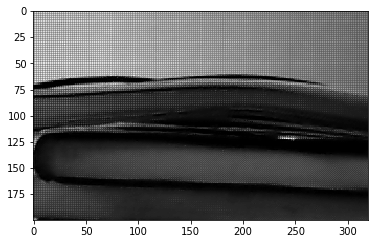

max pixel value=51.8253808226
pixel_value vs exposure


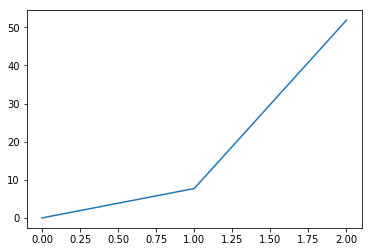

max pixel value=0
(red) pixel_value vs exposure


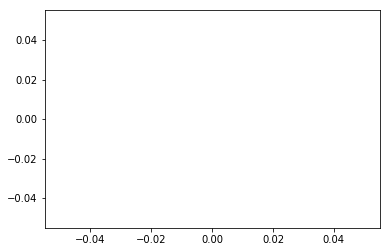

In [37]:
# ALL TOGETHER
num_img = 3;
plt.imshow(get_raw_image()); plt.show();

[images, exposure_times] = get_images(num_img)

#calibration curve
[pixel_values, exposure_times, max_pixel_value] = get_calibration_curve_from_images(images, exposure_times, 0,-1)
print("pixel_value vs exposure"); 
plt.plot(pixel_values);
plt.show();

#calibration curve for read?
cimages = get_color_images(images, 0)
[red_pixel_values, et, red_mpv] = get_calibration_curve_from_images(cimages, exposure_times, 0,-1)
print("(red) pixel_value vs exposure"); 
plt.plot(red_pixel_values); 
plt.show();

make g...
num buckets=3, zmax=66.7856681527
plot g: exposure vs pixel value


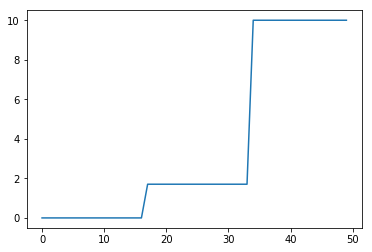

In [25]:
print("make g...")
resp_func = make_g(pixel_values, exposure_times, num_img, 0, max_pixel_value)
print("plot g: exposure vs pixel value"); 
plot_func(resp_func, max_pixel_value)

In [26]:
print("gtable...")
g2 = make_gtable(pixel_values, exposure_times, 0, max_pixel_value)

gtable...
zmax=66.7856681527
5.25140010599
4.94308592102
4.63477173605
4.32645755107
4.0181433661
3.70982918113
3.40151499616
3.09320081119
2.78488662622
2.47657244125
2.16825825628
1.85994407131
1.55162988634
1.24331570137
9.9817548168
9.89521050876
9.80866620072
9.72212189267
9.63557758463
9.54903327659
9.46248896855
9.3759446605
9.28940035246
9.20285604442
9.11631173638
9.02976742833
8.94322312029
8.85667881225
8.7701345042
8.68359019616
8.59704588812
8.51050158008
8.42395727203
8.33741296399
8.25086865595
8.16432434791
8.07778003986
7.99123573182
7.90469142378
7.81814711574
7.73160280769
7.64505849965
7.55851419161
7.47196988356
7.38542557552
7.29888126748
7.21233695944
7.12579265139
7.03924834335
6.95270403531
6.86615972727
6.77961541922
6.69307111118
6.60652680314
6.51998249509
6.43343818705
6.34689387901
6.26034957097
6.17380526292
6.08726095488
6.00071664684
5.9141723388
5.82762803075
5.74108372271
5.65453941467
5.56799510662
[66.785668152675598, 5.2514001059860531, 4.943085921

In [55]:
# construct hdr image
# resp_func = g2
w = make_w(0, max_pixel_value)

new_image = []
image_size = len(images[0])

height = len(images[0] / 10)
width = len(images[0][0] / 10)

# print("scale images...")
# images = scale_image_values(images, max_pixel_value)

spacing = 1

print("start constructing " + str(width) + "x" + str(height) + " image")
for r in range(height):
    if (r % spacing != 0): #skip row
        #new_image += [[100]*(width/2)]
        continue
        
    row = []
    for c in range(width):
        # for each pixel
        if (c % spacing != 0):# skip pixel
            #row += [100]
            continue   
        row += [get_radiance(images, exposure_times, resp_func, w, r, c)]
#         print(get_radiance(images, exposure_times, resp_func, w, r, c))
        
    new_image += [row]
#     print(len(new_image))
    print(r)

print("construction done!")

start constructing 320x200 image
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
oh no
oh no
oh no
oh no

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:173: RuntimeWarning: overflow encountered in double_scalars
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:172: RuntimeWarning: invalid value encountered in double_scalars



oh no
oh no
oh no
oh no
oh no
63
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
64
oh no
oh no
oh no
65
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
66
67
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
68
oh no
69
oh no
oh no
oh no
oh no
oh no
oh no
70
oh no
71
oh no
oh no
oh no
oh no
oh no
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
oh no
oh no
oh no
oh no
oh no
oh no
oh no
101
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
102
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
103
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
104
105
106
107
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh no
oh n

In [30]:
# show hdr image
print(len(images[0]))
print(len(new_image))
print("images[0][0]=\n" + str(images[0][0]))
print("images[30][0]=\n" + str(images[30][0]))
print("images[49][0]=\n" + str(images[49][0]))
plt.imshow(images[0]); plt.show();
plt.imshow(images[30]); plt.show();
plt.imshow(images[49]); plt.show();


200
40
images[0][0]=
[1 1 1 1 1 1 0 0 1 1 1 1 2 1 1 1 1 0 1 1 0 0 1 1 1 1 1 1 2 1 2 2 2 2 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 0 0 0 0 0 0 0 0 0 1 1 1 1 1 2 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


IndexError: list index out of range

new_image[0]=
[26269.326714734154, 325798.58492999565, 21645.862107293287, 303545.31322547689, 22984.316840039897, 152232.43533805327, 22296.383570642527, 168726.88554711686, 23712.638454381136, 331020.18418627774, 26269.326714734154, 210562.60343955661, 25303.892820782236, 237279.15991478914, 26174.434220786497, 353665.92902687425, 29140.400779399286, 208971.8272455699, 28087.509762792404, 237279.15991478914, 27100.671560680879, 269109.49024775444, 26174.434220786497, 269109.49024775444, 30195.920129802969, 331020.18418627774, 33882.988042308039, 180159.39428697265, 33882.988042308039, 575067.11315232853, 30265.417400266178, 331020.18418627774, 33882.988042308039, 210562.60343955661, 29140.400779399286, 237279.15991478914, 32570.29532516349, 331020.18418627774, 24484.62558644234, 269109.49024775444, 23712.638454381136, 210562.60343955661, 28110.710641016591, 227664.8051035089, 29120.227251557037, 331020.18418627774, 28110.710641016591, 138006.55024544982, 25303.892820782236, 152232.43

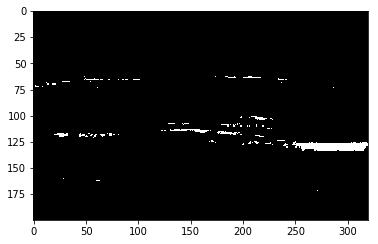

In [57]:
print("new_image[0]=\n" + str(new_image[0]))
plt.imshow(new_image); plt.show();

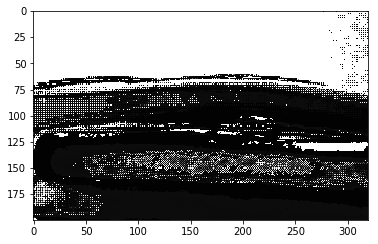

In [64]:
plt.imshow(numpy.clip(new_image,0,10)); plt.show();

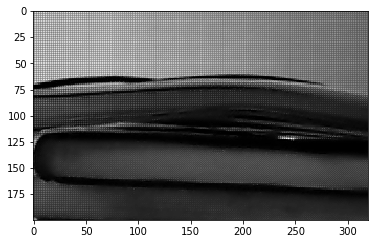

In [54]:
plt.imshow(images[2]); plt.show();